# Scattering for Humidified Particles

In atmospheric conditions, aerosol particles frequently undergo hygroscopic growth, absorbing moisture from the air which leads to an increase in their size. This process of water uptake markedly influences the optical properties of aerosols, affecting how they scatter and absorb light. These changes are crucial, as they directly impact climate and visibility, playing a significant role in atmospheric processes such as radiation balance and cloud formation.

A thorough understanding of Mie scattering parameters for both dry and humidified (or growing) particles provides essential insights into aerosol behavior under varied humidity conditions. By accurately modeling these changes in light scattering and absorption as particles absorb water, we can enhance our predictions regarding aerosols' effects on the atmosphere.

## Imports

To proceed with our analysis, we'll start by importing necessary libraries and modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.util import convert, distribution_discretization
from particula.data.process import mie_bulk

## Base Distribution

This section demonstrates how to create a bimodal log-normal distribution and visualize the number concentration of particles across different diameters.

This code snippet generates a bimodal log-normal distribution characterized by specific modes and a standard deviation. The distribution is then scaled to represent the total number of particles, and the resulting number concentration across diameters is visualized using a logarithmic scale. This approach is particularly useful for simulating aerosol size distributions in atmospheric science, enabling researchers to study particle dynamics and interactions based on their size distribution.

Total number of particles: 999.533377633679


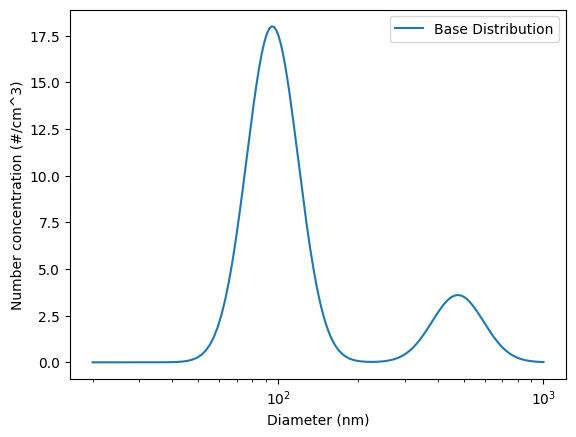

In [2]:
# Define the range and resolution of particle diameters (in nanometers)
diameters = np.linspace(20, 1000, 500)  # From 20 nm to 1000 nm with 500 points

# Standard deviation of the log-normal distribution (dimensionless)
sigma = 1.25

# Define the modes (peak diameters) for a bimodal distribution
modes = [100, 500]

# Total number of particles in the distribution
number_total = 1e3

# Generate a log-normal probability density function (pdf) with an area equal to 1
pdf_dist = distribution_discretization.discretize(
    interval=diameters,  # Array of diameters over which to compute the distribution
    disttype="lognormal",  # Type of distribution
    gsigma=sigma,  # Geometric standard deviation
    mode=modes,  # Modes of the distribution
    nparticles=number_total  # Total number of particles
).m

# Convert the distribution from pdf to probability mass function (pmf)
number_conc_pms = convert.distribution_convert_pdf_pms(
    x_array=diameters,  # Array of diameters
    distribution=pdf_dist,  # The generated pdf
    to_pdf=False  # Specifies the conversion to pmf
) * number_total  # Scale to the total number of particles

# Check the total number of particles are equal to the specified number
print(f"Total number of particles: {np.sum(number_conc_pms)}")

# Visualization
fig, ax = plt.subplots()
ax.plot(diameters, number_conc_pms, label="Base Distribution")
ax.set_xscale("log")  # Logarithmic scale for diameters
ax.set_xlabel("Diameter (nm)")  # X-axis label
ax.set_ylabel("Number concentration (#/cm^3)")  # Y-axis label
ax.legend()  # Show legend
plt.show()  # Display the plot


## Hygroscopic Growth in Aerosol Particles

Aerosol particles in the atmosphere can absorb water, leading to an increase in their size—a process known as hygroscopic growth. This phenomenon is crucial for studying the optical properties and scattering behavior of aerosols because the particle size directly influences how light interacts with these particles. 

### Key Parameters for Hygroscopic Growth:

- **Dry Diameter**: The original size of the particles before absorbing water.
- **Water Activity**: Defined as the relative humidity divided by 100. It is a measure of the moisture content in the air surrounding the particles.
- **Kappa Parameter**: A value that represents the hygroscopicity of the particles, influencing how much water they can absorb under different humidity conditions. The kappa parameter (κ) is used in the kappa-Hygroscopic Growth Factor (HGF) parameterization to model particle growth.

For our analysis, we'll assume a kappa value of 0.61, indicative of ammonium sulfate, a common compound found in atmospheric aerosols. We will explore particle growth at three different water activities (relative humidity levels): 30%, 60%, and 90%.

### Calculating and Visualizing Hygroscopic Growth

The following Python code calculates the change in particle diameters due to hygroscopic growth at low, mid, and high water activity levels and visualizes the base size distribution alongside the grown distributions.

This code section demonstrates how aerosol particles grow in size with increasing humidity, visualized through the changes in their size distribution. Understanding these dynamics is vital for accurately assessing aerosols' environmental and climatic effects.

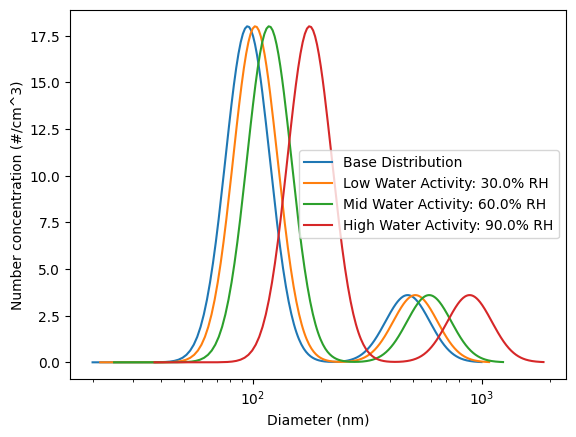

In [3]:
# Hygroscopic growth parameters
kappa = 0.61  # Kappa value for ammonium sulfate
water_activity_low = 0.3  # Low water activity (30% RH)
water_activity_mid = 0.6  # Mid water activity (60% RH)
water_activity_high = 0.9  # High water activity (90% RH)

# Convert particle diameters from the base distribution to volumes
volume_sizer = convert.length_to_volume(diameters, length_type='diameter')

# Calculate water volume absorbed by particles at different RH
volume_water_low = convert.kappa_volume_water(
    volume_solute=volume_sizer,
    kappa=kappa,
    water_activity=water_activity_low)  # showing the input parameters
volume_water_mid = convert.kappa_volume_water(
    volume_sizer, kappa, water_activity_mid)
volume_water_high = convert.kappa_volume_water(
    volume_sizer, kappa, water_activity_high)

# Calculate new particle diameters after hygroscopic growth
diameters_low = convert.volume_to_length(
    volume=volume_sizer + volume_water_low,
    length_type='diameter')  # showing the input parameters
diameters_mid = convert.volume_to_length(
    volume_sizer + volume_water_mid, 'diameter')
diameters_high = convert.volume_to_length(
    volume_sizer + volume_water_high, 'diameter')

# Plotting the base and grown size distributions
fig, ax = plt.subplots()
ax.plot(diameters, number_conc_pms, label="Base Distribution")
ax.plot(
    diameters_low,
    number_conc_pms,
    label=f"Low Water Activity: {water_activity_low*100}% RH")
ax.plot(
    diameters_mid,
    number_conc_pms,
    label=f"Mid Water Activity: {water_activity_mid*100}% RH")
ax.plot(
    diameters_high,
    number_conc_pms,
    label=f"High Water Activity: {water_activity_high*100}% RH")
ax.set_xscale("log")
ax.set_xlabel("Diameter (nm)")
ax.set_ylabel("Number concentration (#/cm^3)")
ax.legend()
plt.show()

## Refractive Index Mixing Rule

Upon determining the sizes of both wet and dry particles, we proceed to calculate the refractive index for these humidified particles. This calculation employs the Lorentz-Lorenz mixing rule, a straightforward approximation for the refractive index of a mixture comprising two substances. The mixing rule, as detailed by Liu & Daum (2008), underpins the implementation in the `convert.effective_refractive_index` module, facilitating the computation of the humidified particle's refractive index.

### Effective Refractive Index Calculation
The effective refractive index $n_{\text{effective}}$ for a binary mixture can be derived using molar refraction mixing, as described in the referenced study. The formula is based on the volumes and refractive indices of the individual components:

$$
r_{\text{effective}} = \frac{V_0}{V_{\text{total}}} \cdot \frac{m_0 - 1}{m_0 + 2} + \frac{V_1}{V_{\text{total}}} \cdot \frac{m_1 - 1}{m_1 + 2}
$$

Where:
- $V_0$ and $V_1$ are the volumes of components 0 and 1, respectively.
- $V_{\text{total}} = V_0 + V_1$ is the total volume.
- $m_0$ and $m_1$ are the refractive indices of components 0 and 1, respectively.
- $r_{\text{effective}}$ is the effective specific refraction.

The effective refractive index is then calculated from $r_{\text{effective}}$ as follows:

$$
n_{\text{effective}} = \frac{2R_{\text{effective}} + 1}{1 - R_{\text{effective}}}
$$

This equation allows for the calculation of the effective refractive index of the mixture, accounting for the volumetric contributions and specific refraction of each component.

**Reference**
Liu, Y., & Daum, P. H. (2008). Relationship of refractive index to mass density and self-consistency mixing rules for multicomponent mixtures like ambient aerosols. *Journal of Aerosol Science, 39(11)*, 974-986. [https://doi.org/10.1016/j.jaerosci.2008.06.006](https://doi.org/10.1016/j.jaerosci.2008.06.006)

In [4]:
# Define the refractive index of dry particle material and water
refractive_index_dry = 1.5 + 0.5j  # Dimensionless
refractive_index_water = 1.33  # Dimensionless

# Calculate effective refractive indices for each water activity level,
# utilizing the volumes of each component
n_effective_low = convert.effective_refractive_index(
    m_zero=refractive_index_dry,
    m_one=refractive_index_water,
    volume_zero=volume_sizer[-1],
    volume_one=volume_water_low[-1]
)
n_effective_mid = convert.effective_refractive_index(
    m_zero=refractive_index_dry,
    m_one=refractive_index_water,
    volume_zero=volume_sizer[-1],
    volume_one=volume_water_mid[-1]
)
n_effective_high = convert.effective_refractive_index(
    m_zero=refractive_index_dry,
    m_one=refractive_index_water,
    volume_zero=volume_sizer[-1],
    volume_one=volume_water_high[-1]
)

# Output the effective refractive indices
print(f"Effective Refractive Index at Low Water Activity: {n_effective_low}")
print(f"Effective Refractive Index at Mid Water Activity: {n_effective_mid}")
print(f"Effective Refractive Index at High Water Activity: {n_effective_high}")

Effective Refractive Index at Low Water Activity: (1.475296758061568+0.3877520937699365j)
Effective Refractive Index at Mid Water Activity: (1.4339992549471252+0.24759591899911076j)
Effective Refractive Index at High Water Activity: (1.363603614921365+0.06976083730498348j)


## Calculating Optical Properties of Humidified Particles

With the sizes and refractive indices of both dry and humidified particles determined, we now turn our attention to calculating their optical properties, including scattering and absorption. These properties are crucial for understanding the particles' behavior in the atmosphere and their potential climate impacts. We leverage the `mie_bulk.mie_size_distribution` function to compute these properties across different humidity conditions.

### Implementation Details

The Python code below demonstrates how to calculate the optical properties for particles at varying levels of humidity using Mie scattering theory. These calculations provide insights into how hygroscopic growth affects the particles' ability to scatter and absorb light.

This segment calculates and then plots the extinction, scattering, and absorption coefficients for particles at different levels of hygroscopic growth. The `water_activity_series` corresponds to the range of humidity conditions under consideration, providing a clear visual representation of how water uptake influences the optical properties of aerosol particles.

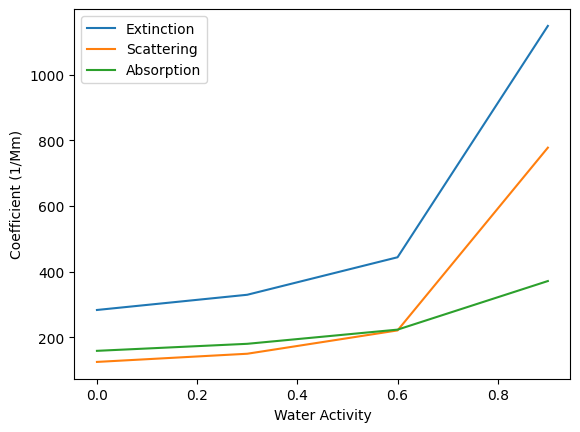

In [5]:
# Define the wavelength of incident light in nanometers
wavelength = 550

# Calculate optical properties for dry and humidified particles
optics_dry = mie_bulk.mie_size_distribution(
    m_sphere=refractive_index_dry,
    wavelength=wavelength,
    diameter=diameters,
    number_per_cm3=number_conc_pms,
    pms=True,
    discretize=False
)

optics_low = mie_bulk.mie_size_distribution(
    m_sphere=n_effective_low,
    wavelength=wavelength,
    diameter=diameters_low,
    number_per_cm3=number_conc_pms,
    pms=True,
    discretize=False
)

optics_mid = mie_bulk.mie_size_distribution(
    m_sphere=n_effective_mid,
    wavelength=wavelength,
    diameter=diameters_mid,
    number_per_cm3=number_conc_pms,
    pms=True,
    discretize=False
)

optics_high = mie_bulk.mie_size_distribution(
    m_sphere=n_effective_high,
    wavelength=wavelength,
    diameter=diameters_high,
    number_per_cm3=number_conc_pms,
    pms=True,
    discretize=False
)

# Combine the results for visualization
combined_optics = np.vstack((optics_dry, optics_low, optics_mid, optics_high))
water_activity_series = [0, water_activity_low, water_activity_mid, water_activity_high]

# Visualization of optical properties across different humidity levels
fig, ax = plt.subplots()
ax.plot(water_activity_series, combined_optics[:, 0], label="Extinction")
ax.plot(water_activity_series, combined_optics[:, 1], label="Scattering")
ax.plot(water_activity_series, combined_optics[:, 2], label="Absorption")
ax.set_xlabel("Water Activity")
ax.set_ylabel("Coefficient (1/Mm)")
ax.legend()
plt.show()

## Summary

In this notebook, we delved into the phenomenon of hygroscopic growth of aerosol particles and investigated its consequential effects on their optical characteristics. Our journey commenced with the construction of a bimodal log-normal distribution, aimed at depicting the number concentration of aerosol particles across a spectrum of diameters. This foundational step allowed us to simulate the real-world complexity of aerosol size distributions.

Moving forward, we calculated the hygroscopic growth of these particles under different humidity conditions, employing varying water activities to simulate environmental changes. Through visualization, we effectively illustrated the shifts in particle size distribution resulting from this growth, providing a clear depiction of how particles expand as they absorb moisture.

In our subsequent analysis, we determined the refractive index of the humidified particles. This was achieved by applying the Lorentz-Lorenz mixing rule, a theoretical framework that facilitated the computation of the effective refractive index of the particles post-hydration.

Our exploration ended in the calculation of the optical properties of aerosol particles across different levels of humidity. By doing so, we unveiled the ways in which hygroscopic growth influences the scattering and absorption behaviors of particles. The insights garnered from this analysis are instrumental in comprehending the broader implications of particle growth on atmospheric optics and climate dynamics.

As we proceed, our focus will shift towards finding the kappa parameter based on empirical measurements of particle sizes and extinction coefficients. This reverse engineering process is a common challenge in atmospheric science, offering a deeper understanding of aerosol properties through observational data. Our exploration into this inverse problem marks the next step in bridging theoretical models with practical atmospheric measurements, enhancing our ability to interpret and predict aerosol behavior in the Earth's atmosphere.

In [6]:
help(convert.kappa_volume_water)

Help on function kappa_volume_water in module particula.util.convert:

kappa_volume_water(volume_solute: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], kappa: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], water_activity: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
    Calculate the volume of water given volume of solute, kappa parameter,
    and water activity.
    
    Args:
    -----------
        volume_solute: The volume of solute.
        kappa: The kappa parameter.
        water_activity: The water activity.
    
    Returns:
    --------
        The volume of water as a float.



In [7]:
help(convert.effective_refractive_index)

Help on function effective_refractive_index in module particula.util.convert:

effective_refractive_index(m_zero: Union[float, complex], m_one: Union[float, complex], volume_zero: float, volume_one: float) -> Union[float, complex]
    Calculate the effective refractive index of a mixture of two solutes, given
    the refractive index of each solute and the volume of each solute. The
    mixing is based on volume-weighted molar refraction.
    
    Args:
    -----------
        m_zero (float or complex): The refractive index of solute 0.
        m_one (float or complex): The refractive index of solute 1.
        volume_zero (float): The volume of solute 0.
        volume_one (float): The volume of solute 1.
    
    Returns:
    -----------
        The effective refractive index of the mixture.
    
    Reference:
    -----------
        Liu, Y., &#38; Daum, P. H. (2008).
        Relationship of refractive index to mass density and self-consistency
        mixing rules for multicomponen